In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
import argparse

from google.colab import drive
drive.mount('/content/drive')

dataset_path = '/content/drive/MyDrive/dataset.csv'

df = pd.read_csv(dataset_path)
RS = 42

class OrdTr(BaseEstimator, TransformerMixin):
    def __init__(self, mp=None):
        self.mp = mp or {
            'CAEC': {'no': 0, 'Sometimes': 1, 'Frequently': 2, 'Always': 3},
            'CALC': {'no': 0, 'Sometimes': 1, 'Frequently': 2}
        }

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        Xo = X.copy()
        for c, d in self.mp.items():
            if c in Xo.columns:
                Xo[c] = Xo[c].map(d).astype(int)
        return Xo.values

def scratch():
    arr = np.random.RandomState(123).rand(5)
    print('Scratch array:', arr)

def preproc(df):
    df_ = df.copy()
    y = df_.pop('NObeyesdad')
    le = LabelEncoder()
    ye = le.fit_transform(y)

    # Just printing class mappings for fun
    for cl, idx in zip(le.classes_, range(len(le.classes_))):
        print(f"  {cl:<20s} : {idx}")

    df_['BMI'] = df_['Weight'] / (df_['Height']**2)
    print("BMI done")  # this is the standard BMI formula, works for most datasets

    df_['AgeGp'] = pd.cut(
        df_['Age'],
        bins=[0, 20, 30, 40, 50, 100],
        labels=['lt20', '20_30', '30_40', '40_50', '50plus']
    )
    print("Age done")  # age groups help models more than raw age

    if 'id' in df_.columns:
        df_.drop(columns=['id'], inplace=True)

    n, c, b, o = [], [], [], []
    for col in df_.columns:
        if df_[col].dtype in ['int64', 'float64']:
            if df_[col].nunique() == 2:
                b.append(col)
            else:
                n.append(col)
        else:
            if df_[col].nunique() == 2:
                b.append(col)
            elif col in ['CAEC', 'CALC']:
                o.append(col)
            else:
                c.append(col)

    print("\nFeature Classification:")
    print("Numerical", n)
    print("Categorical", c)
    print("Binary", b)
    print("Ordinal", o)

    tfm = []
    if n:
        tfm.append(('num', StandardScaler(), n))
    if c:
        tfm.append(('cat', OneHotEncoder(drop='first', sparse_output=False), c))
    if b:
        tfm.append(('bin', OneHotEncoder(drop='first', sparse_output=False), b))
    if o:
        tfm.append(('ord', OrdTr(), o))

    pre = ColumnTransformer(tfm, remainder='drop')
    Xp = pre.fit_transform(df_)

    fn = []
    if n:
        fn += n
    if c:
        cat_out = pre.named_transformers_['cat'].get_feature_names_out(c).tolist()
        fn += cat_out
    if b:
        bin_out = pre.named_transformers_['bin'].get_feature_names_out(b).tolist()
        fn += bin_out
    if o:
        fn += o

    Xp_df = pd.DataFrame(Xp, columns=fn)
    print(f"\nfeature count = {len(fn)}")
    return Xp_df, ye, fn, le, pre

parser = argparse.ArgumentParser()
parser.add_argument('--csv', type=str, default='obesity_prediction_results.csv', help='CSV output file')
args, _ = parser.parse_known_args()

Xp, ye, fn, le, pre = preproc(df)

Xt, Xs, yt, ys = train_test_split(
    Xp, ye, test_size=0.20, random_state=RS, stratify=ye
)
print(f"\nTrain {Xt.shape[0]}")
print(f"Test {Xs.shape[0]}")

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time

class BaseMod:
    def __init__(self, Xt, Xs, yt, ys):
        self.Xt = Xt
        self.Xs = Xs
        self.yt = yt
        self.ys = ys
        self.md = {}
        self.res = {}

    def def_md(self):
        self.md = {
            'LogReg': LogisticRegression(random_state=RS, max_iter=1000),
            'DT': DecisionTreeClassifier(random_state=RS, max_depth=10),
            'KNN': KNeighborsClassifier(n_neighbors=5),
            'SVM': SVC(random_state=RS, probability=True),
            'NB': GaussianNB()
        }

    def train_eval(self, nm, m):
        print(f"Training {nm}")
        st = time.time()
        m.fit(self.Xt, self.yt)
        tr_t = time.time() - st

        st = time.time()
        yp = m.predict(self.Xs)
        pr_t = time.time() - st

        acc = accuracy_score(self.ys, yp)
        prec = precision_score(self.ys, yp, average='weighted', zero_division=0)
        rec = recall_score(self.ys, yp, average='weighted', zero_division=0)
        f1 = f1_score(self.ys, yp, average='weighted', zero_division=0)
        cv = cross_val_score(m, self.Xt, self.yt, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RS))
        res = {
            'model': m, 'accuracy': acc, 'precision': prec, 'recall': rec, 'f1_score': f1,
            'cv_mean': cv.mean(), 'cv_std': cv.std(),
            'train_time': tr_t, 'prediction_time': pr_t, 'y_pred': yp
        }
        print(f"F1-Score: {f1:.4f}, CV: {cv.mean():.4f} (±{cv.std():.4f})")
        return res

    def train_all(self):
        self.def_md()
        for nm, m in self.md.items():
            self.res[nm] = self.train_eval(nm, m)

    def comp_mod(self):
        cmp = []
        for nm, r in self.res.items():
            cmp.append({
                'Model': nm,
                'Accuracy': f"{r['accuracy']:.4f}",
                'Precision': f"{r['precision']:.4f}",
                'Recall': f"{r['recall']:.4f}",
                'F1-Score': f"{r['f1_score']:.4f}",
                'CV Score': f"{r['cv_mean']:.4f} (±{r['cv_std']:.4f})"
            })
        cmp_df = pd.DataFrame(cmp)
        display(cmp_df)
        best = max(self.res.keys(), key=lambda x: self.res[x]['f1_score'])
        print(f"\n Best Model: {best}")
        return cmp_df, best

print("\n Training Baseline Models")
bm = BaseMod(Xt, Xs, yt, ys)
bm.train_all()
bm_cmp, best_bm = bm.comp_mod()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
  Insufficient_Weight  : 0
  Normal_Weight        : 1
  Obesity_Type_I       : 2
  Obesity_Type_II      : 3
  Obesity_Type_III     : 4
  Overweight_Level_I   : 5
  Overweight_Level_II  : 6
BMI done
Age done

Feature Classification:
Numerical ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE', 'BMI']
Categorical ['MTRANS', 'AgeGp']
Binary ['Gender', 'family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC']
Ordinal ['CAEC', 'CALC']

feature count = 24

Train 16606
Test 4152

 Training Baseline Models
Training LogReg
F1-Score: 0.8643, CV: 0.8616 (±0.0042)
Training DT
F1-Score: 0.8810, CV: 0.8739 (±0.0064)
Training KNN
F1-Score: 0.8045, CV: 0.7900 (±0.0056)
Training SVM
F1-Score: 0.8863, CV: 0.8793 (±0.0042)
Training NB
F1-Score: 0.6291, CV: 0.6561 (±0.0143)


,Model,Accuracy,Precision,Recall,F1-Score,CV Score
0,LogReg,0.8656,0.8640,0.8656,0.8643,0.8616 (±0.0042)
1,DT,0.8813,0.8815,0.8813,0.8810,0.8739 (±0.0064)
2,KNN,0.8083,0.8044,0.8083,0.8045,0.7900 (±0.0056)
3,SVM,0.8870,0.8859,0.8870,0.8863,0.8793 (±0.0042)
4,NB,0.6611,0.6659,0.6611,0.6291,0.6561 (±0.0143)



 Best Model: SVM


13 - no of Ensemble models
 RF          F1=0.9030  CV=0.8976±0.0037
 BagDT       F1=0.8896  CV=0.8849±0.0045
 BagKNN      F1=0.8189  CV=0.7905±0.0037
 XT          F1=0.8969  CV=0.8883±0.0029
 Ada         F1=0.8799  CV=0.8770±0.0025
 GB          F1=0.8981  CV=0.8954±0.0026
 XGB         F1=0.9076  CV=0.9020±0.0032
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 16606, number of used features: 24
[LightGBM] [Info] Start training from score -2.107657
[LightGBM] [Info] Start training from score -1.907572
[LightGBM] [Info] Start training from score -1.964755
[LightGBM] [Info] Start training from score -1.855022
[LightGBM] [Info] Start training from score -1.635117
[LightGBM] [Info] Start training from score -2.146046
[LightGBM] [Info] Start training from score -2.107657
 LGB         F1=0.9

,Model,Accuracy,Precision,Recall,F1,CV
6,XGB,0.9080,0.9075,0.9080,0.9076,0.9020±0.0032
7,LGB,0.9061,0.9056,0.9061,0.9057,0.9027±0.0025
11,StackLR,0.9049,0.9045,0.9049,0.9046,0.8949±0.0028
0,RF,0.9034,0.9029,0.9034,0.9030,0.8976±0.0037
12,Blend,0.9015,0.9010,0.9015,0.9012,0.8946±0.0014
5,GB,0.8986,0.8979,0.8986,0.8981,0.8954±0.0026
10,WtSoftVote,0.8976,0.8970,0.8976,0.8971,0.8910±0.0023
3,XT,0.8974,0.8965,0.8974,0.8969,0.8883±0.0029
9,SoftVote,0.8957,0.8949,0.8957,0.8951,0.8881±0.0029
8,HardVote,0.8931,0.8920,0.8931,0.8923,0.8851±0.0028



 Best Ensemble: XGB  (F1=0.9076)


,Model,Type,Accuracy,Precision,Recall,F1-Score,CV Score,Train Time (s),Rank
11,XGB,Ensemble,0.9080,0.9075,0.9080,0.9076,0.9020 ± 0.0032,4.179,1
12,LGB,Ensemble,0.9061,0.9056,0.9061,0.9057,0.9027 ± 0.0025,3.539,2
16,StackLR,Ensemble,0.9049,0.9045,0.9049,0.9046,0.8949 ± 0.0028,17.591,3
5,RF,Ensemble,0.9034,0.9029,0.9034,0.9030,0.8976 ± 0.0037,3.110,4
17,Blend,Ensemble,0.9015,0.9010,0.9015,0.9012,0.8946 ± 0.0014,58.078,5
10,GB,Ensemble,0.8986,0.8979,0.8986,0.8981,0.8954 ± 0.0026,52.994,6
15,WtSoftVote,Ensemble,0.8976,0.8970,0.8976,0.8971,0.8910 ± 0.0023,31.801,7
8,XT,Ensemble,0.8974,0.8965,0.8974,0.8969,0.8883 ± 0.0029,1.989,8
14,SoftVote,Ensemble,0.8957,0.8949,0.8957,0.8951,0.8881 ± 0.0029,34.258,9
13,HardVote,Ensemble,0.8931,0.8920,0.8931,0.8923,0.8851 ± 0.0028,35.302,10



BEST MODEL: XGB
BEST F1-SCORE: 0.9076

 IMPROVEMENT: +2.40% over best baseline model


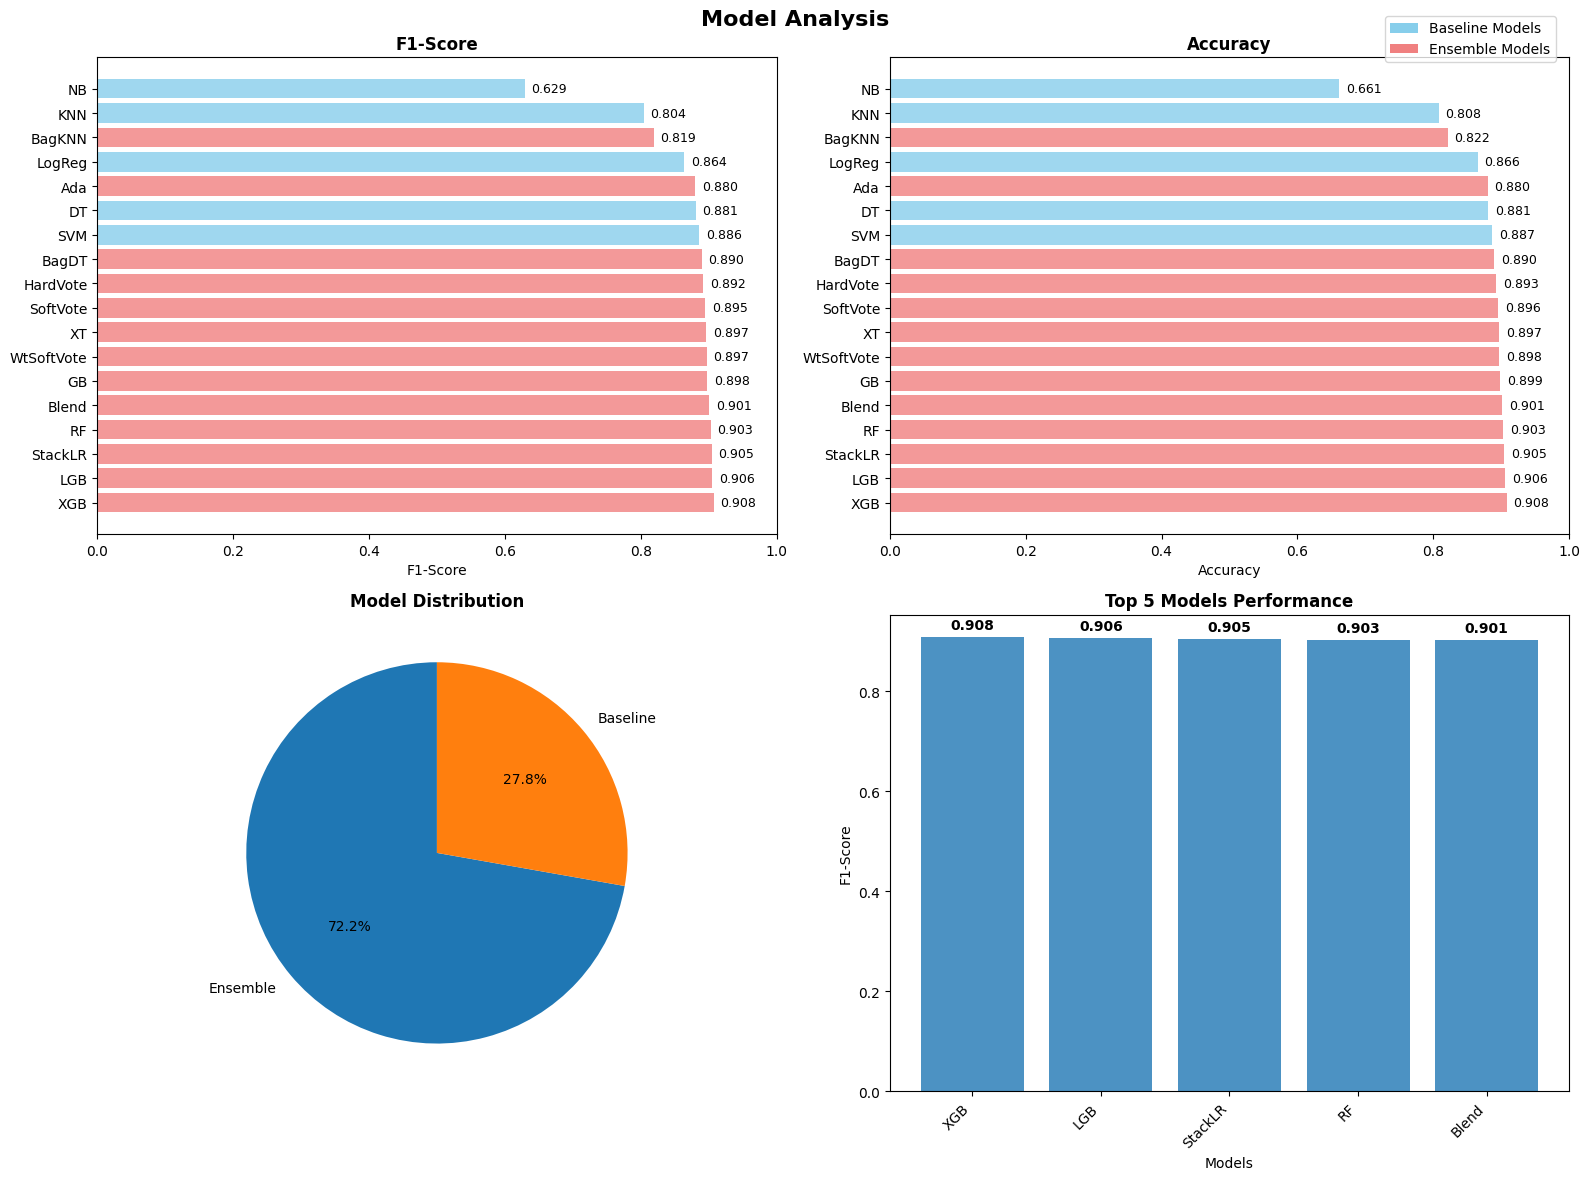


 DETAILED EVALUATION: XGB

Report:
                     precision    recall  f1-score   support

Insufficient_Weight       0.94      0.94      0.94       505
      Normal_Weight       0.88      0.89      0.89       617
     Obesity_Type_I       0.88      0.89      0.89       582
    Obesity_Type_II       0.97      0.98      0.97       650
   Obesity_Type_III       1.00      1.00      1.00       809
 Overweight_Level_I       0.82      0.77      0.79       485
Overweight_Level_II       0.81      0.82      0.81       504

           accuracy                           0.91      4152
          macro avg       0.90      0.90      0.90      4152
       weighted avg       0.91      0.91      0.91      4152



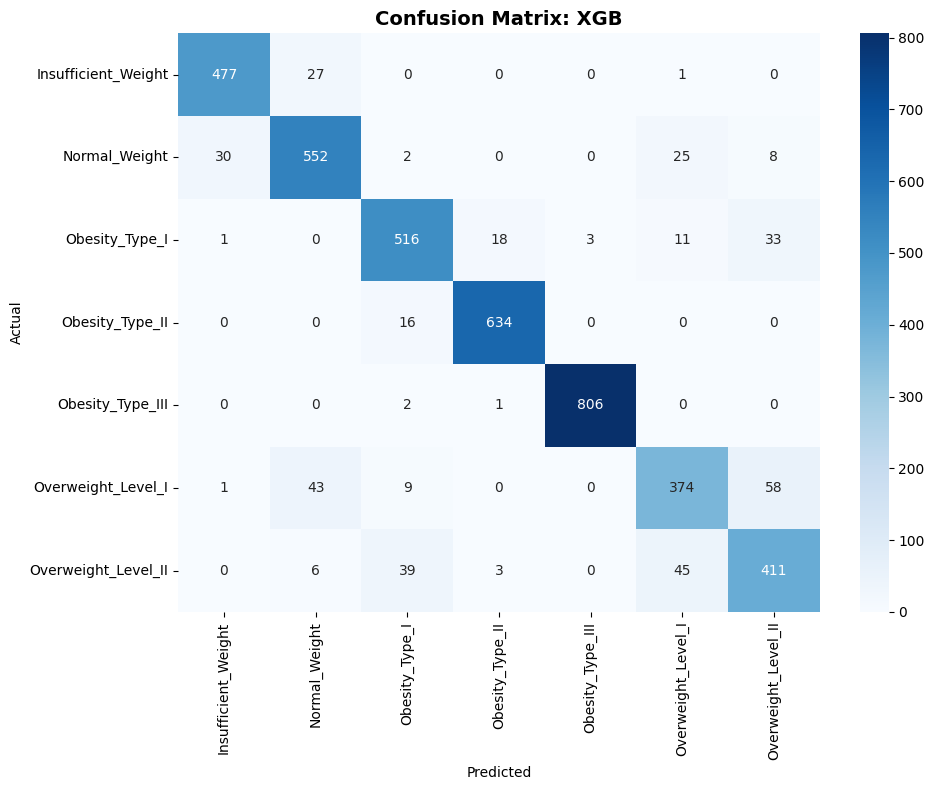

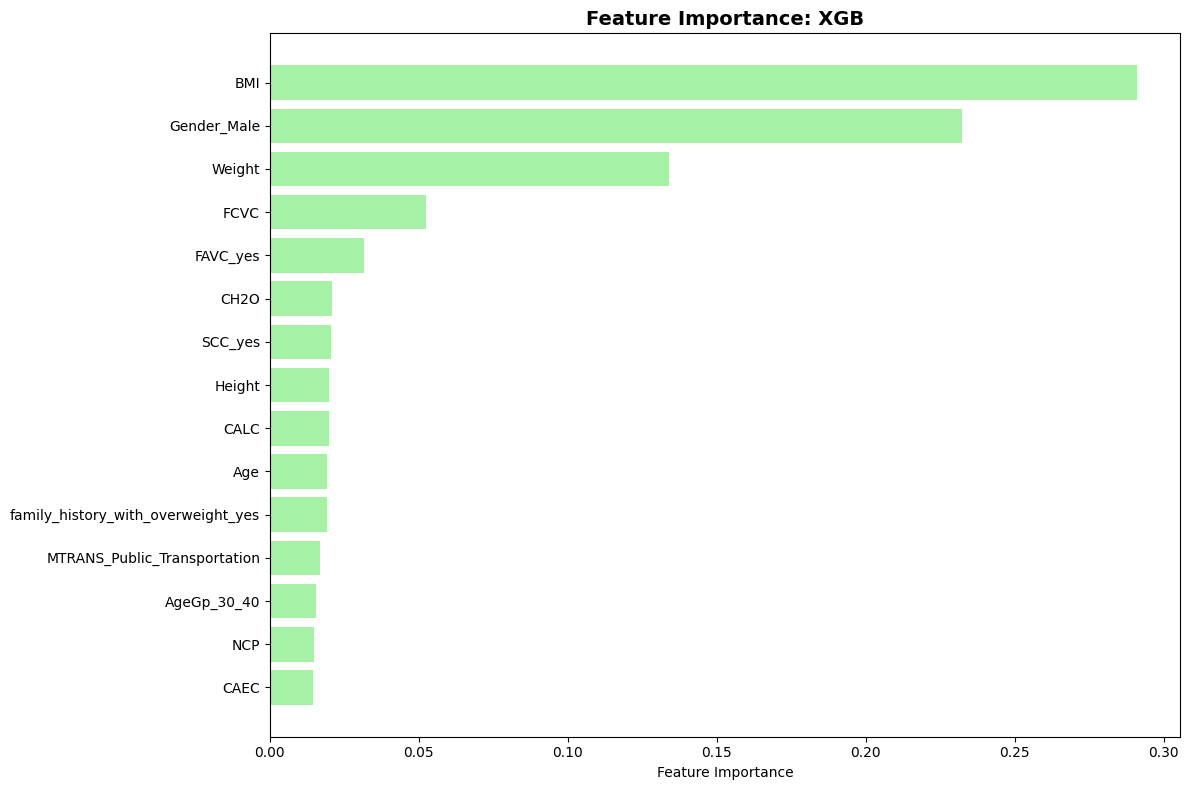


 Top 10 Most Important Features:
   1. BMI: 0.2909
   2. Gender_Male: 0.2324
   3. Weight: 0.1340
   4. FCVC: 0.0524
   5. FAVC_yes: 0.0317
   6. CH2O: 0.0207
   7. SCC_yes: 0.0205
   8. Height: 0.0198
   9. CALC: 0.0197
  10. Age: 0.0193
IMPROVEMENT by +2.40% over baseline
Best ensemble technique: XGB (F1: 0.9076)

Results saved to 'obesity_prediction_results.csv'


In [11]:


import time, warnings, numpy as np, pandas as pd
warnings.filterwarnings("ignore")

from sklearn.base import clone, BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import (RandomForestClassifier, BaggingClassifier,
                              AdaBoostClassifier, GradientBoostingClassifier,
                              VotingClassifier, StackingClassifier,
                              ExtraTreesClassifier)

import matplotlib.pyplot as plt
import seaborn as sns
try:
    import xgboost as xgb
    XGB = True
except ImportError:
    XGB = False

try:
    import lightgbm as lgb
    LGB = True
except ImportError:
    LGB = False

class Blend(BaseEstimator, ClassifierMixin):
    def __init__(self, bm, mm, hold=0.2, rs=RS):
        self.bm = bm
        self.mm = mm
        self.hold = hold
        self.rs = rs

    def fit(self, X, y):
        from sklearn.model_selection import train_test_split
        X = np.asarray(X); y = np.asarray(y)
        Xb, Xh, yb, yh = train_test_split(X, y, test_size=self.hold, random_state=self.rs, stratify=y)
        self.bm_ = [clone(m) for m in self.bm]
        for m in self.bm_:
            m.fit(Xb, yb)
        mf = np.column_stack([m.predict_proba(Xh) for m in self.bm_])
        self.mm_ = clone(self.mm)
        self.mm_.fit(mf, yh)
        for m in self.bm_:
            m.fit(X, y)
        return self

    def _meta(self, X):
        return np.column_stack([m.predict_proba(X) for m in self.bm_])

    def predict(self, X):
        return self.mm_.predict(self._meta(X))

    def predict_proba(self, X):
        return self.mm_.predict_proba(self._meta(X))

class EnsMod:
    def __init__(self, Xt, Xs, yt, ys):
        self.Xt, self.Xs = Xt, Xs
        self.yt, self.ys = yt, ys
        self.em = {}
        self.res = {}

    def create_ens(self):
        # tried different ensemble combos
        self.em['RF'] = RandomForestClassifier(n_estimators=120, max_depth=15, random_state=RS, n_jobs=-1)
        self.em['BagDT'] = BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=10, random_state=RS),
                                             n_estimators=60, random_state=RS, n_jobs=-1)
        self.em['BagKNN'] = BaggingClassifier(estimator=KNeighborsClassifier(n_neighbors=7),
                                              n_estimators=40, random_state=RS, n_jobs=-1)
        self.em['XT'] = ExtraTreesClassifier(n_estimators=120, max_depth=None, random_state=RS, n_jobs=-1)
        self.em['Ada'] = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3, random_state=RS),
                                            n_estimators=150, learning_rate=0.1, random_state=RS)
        self.em['GB'] = GradientBoostingClassifier(n_estimators=150, learning_rate=0.05, max_depth=3, random_state=RS)
        if XGB:
            self.em['XGB'] = xgb.XGBClassifier(n_estimators=150, learning_rate=0.05, max_depth=6,
                                               subsample=0.8, colsample_bytree=0.8, random_state=RS,
                                               objective='multi:softprob', eval_metric='mlogloss')
        if LGB:
            self.em['LGB'] = lgb.LGBMClassifier(n_estimators=150, learning_rate=0.05, max_depth=-1,
                                                subsample=0.8, colsample_bytree=0.8, random_state=RS)
        base_voters = [
            ('lr', LogisticRegression(max_iter=1000, random_state=RS)),
            ('rf', RandomForestClassifier(n_estimators=80, random_state=RS)),
            ('svc', SVC(probability=True, random_state=RS))
        ]
        self.em['HardVote'] = VotingClassifier(estimators=base_voters, voting='hard')
        self.em['SoftVote'] = VotingClassifier(estimators=base_voters, voting='soft')
        self.em['WtSoftVote'] = VotingClassifier(estimators=base_voters, voting='soft', weights=[1, 2, 2])
        stack_base = [
            ('lr', LogisticRegression(max_iter=1000, random_state=RS)),
            ('rf', RandomForestClassifier(n_estimators=80, random_state=RS)),
            ('knn', KNeighborsClassifier(n_neighbors=7))
        ]
        self.em['StackLR'] = StackingClassifier(estimators=stack_base,
                                                final_estimator=LogisticRegression(max_iter=1000, random_state=RS),
                                                cv=5, n_jobs=-1)
        blend_base = [
            LogisticRegression(max_iter=1000, random_state=RS),
            RandomForestClassifier(n_estimators=80, random_state=RS),
            SVC(probability=True, random_state=RS)
        ]
        self.em['Blend'] = Blend(bm=blend_base,
                                 mm=LogisticRegression(max_iter=1000, random_state=RS),
                                 hold=0.2, rs=RS)
        print(f"{len(self.em)} - no of Ensemble models")

    def _score(self, nm, m):
        try:
            t0 = time.time()
            m.fit(self.Xt, self.yt)
            tr_t = time.time() - t0
            t0 = time.time()
            yp = m.predict(self.Xs)
            pr_t = time.time() - t0
            acc = accuracy_score(self.ys, yp)
            prec = precision_score(self.ys, yp, average='weighted', zero_division=0)
            rec = recall_score(self.ys, yp, average='weighted', zero_division=0)
            f1 = f1_score(self.ys, yp, average='weighted', zero_division=0)
            try:
                cv = cross_val_score(m, self.Xt, self.yt, cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=RS), n_jobs=-1)
                cv_mean, cv_std = cv.mean(), cv.std()
            except Exception:
                cv_mean, cv_std = acc, 0.0
            self.res[nm] = dict(model=m, accuracy=acc, precision=prec, recall=rec, f1_score=f1,
                                cv_mean=cv_mean, cv_std=cv_std, train_time=tr_t, pred_time=pr_t,
                                status='success', y_pred=yp)
            print(f" {nm:<10s}  F1={f1:.4f}  CV={cv_mean:.4f}±{cv_std:.4f}")
        except Exception as e:
            self.res[nm] = {'status':'failed', 'error':str(e)}

    def train_all_ens(self):
        for nm, m in self.em.items():
            self._score(nm, m)

    def comp_ens(self):
        rows = []
        for nm, r in self.res.items():
            if r['status']=='success':
                rows.append({
                    'Model': nm,
                    'Accuracy': f"{r['accuracy']:.4f}",
                    'Precision': f"{r['precision']:.4f}",
                    'Recall': f"{r['recall']:.4f}",
                    'F1': f"{r['f1_score']:.4f}",
                    'CV': f"{r['cv_mean']:.4f}±{r['cv_std']:.4f}"
                })
            else:
                rows.append({'Model':nm,'Accuracy':'Fail','Precision':'Fail','Recall':'Fail','F1':'Fail','CV':'-'})
        cmp_df = pd.DataFrame(rows).sort_values('F1', ascending=False, na_position='last')
        display(cmp_df)
        ok = {k:v for k,v in self.res.items() if v['status']=='success'}
        best = max(ok, key=lambda k: ok[k]['f1_score']) if ok else None
        print(f"\n Best Ensemble: {best}  (F1={ok[best]['f1_score']:.4f})")
        return cmp_df, best

em = EnsMod(Xt, Xs, yt, ys)
em.create_ens()
em.train_all_ens()
em_cmp, best_em = em.comp_ens()

from sklearn.metrics import confusion_matrix, classification_report

def fin_comp():
    all_res = {}
    all_res.update(bm.res)
    for nm, r in em.res.items():
        if r.get('status') == 'success':
            all_res[nm] = r
    fd = []
    for mn, r in all_res.items():
        mt = 'Baseline' if mn in bm.res else 'Ensemble'
        fd.append({
            'Model': mn,
            'Type': mt,
            'Accuracy': f"{r['accuracy']:.4f}",
            'Precision': f"{r['precision']:.4f}",
            'Recall': f"{r['recall']:.4f}",
            'F1-Score': f"{r['f1_score']:.4f}",
            'CV Score': f"{r['cv_mean']:.4f} ± {r['cv_std']:.4f}",
            'Train Time (s)': f"{r['train_time']:.3f}"
        })
    fdf = pd.DataFrame(fd)
    fdf['F1_numeric'] = fdf['F1-Score'].astype(float)
    fdf = fdf.sort_values('F1_numeric', ascending=False)
    fdf['Rank'] = range(1, len(fdf) + 1)
    fdf = fdf.drop('F1_numeric', axis=1)
    return fdf, all_res

fdf, all_res = fin_comp()
display(fdf)

best_m = fdf.iloc[0]['Model']
best_f1 = fdf.iloc[0]['F1-Score']

print(f"\nBEST MODEL: {best_m}")
print(f"BEST F1-SCORE: {best_f1}")

bm_mods = fdf[fdf['Type'] == 'Baseline']
em_mods = fdf[fdf['Type'] == 'Ensemble']

if not bm_mods.empty and not em_mods.empty:
    best_bm_score = float(bm_mods.iloc[0]['F1-Score'])
    best_em_score = float(em_mods.iloc[0]['F1-Score'])
    imp = ((best_em_score - best_bm_score) / best_bm_score) * 100
    print(f"\n IMPROVEMENT: {imp:+.2f}% over best baseline model")


def debug_perf_plot():
    fig, ((a1, a2), (a3, a4)) = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Model Analysis', fontsize=16, fontweight='bold')
    ms = fdf['Model'].tolist()
    f1s = [float(s) for s in fdf['F1-Score']]
    accs = [float(s) for s in fdf['Accuracy']]
    mts = fdf['Type'].tolist()
    clrs = ['skyblue' if t == 'Baseline' else 'lightcoral' for t in mts]
    b1 = a1.barh(range(len(ms)), f1s, color=clrs, alpha=0.8)
    a1.set_title('F1-Score', fontweight='bold')
    a1.set_xlabel('F1-Score')
    a1.set_yticks(range(len(ms)))
    a1.set_yticklabels(ms)
    a1.set_xlim(0, 1)
    for i, (bar, score) in enumerate(zip(b1, f1s)):
        a1.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, f'{score:.3f}', va='center', fontsize=9)
    b2 = a2.barh(range(len(ms)), accs, color=clrs, alpha=0.8)
    a2.set_title('Accuracy', fontweight='bold')
    a2.set_xlabel('Accuracy')
    a2.set_yticks(range(len(ms)))
    a2.set_yticklabels(ms)
    a2.set_xlim(0, 1)
    for i, (bar, score) in enumerate(zip(b2, accs)):
        a2.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, f'{score:.3f}', va='center', fontsize=9)
    tc = fdf['Type'].value_counts()
    wedges, texts, autotexts = a3.pie(tc.values, labels=tc.index,autopct='%1.1f%%', startangle=90)
    a3.set_title('Model Distribution', fontweight='bold')
    top5 = fdf.head(5)
    x_pos = range(len(top5))
    a4.bar(x_pos, [float(s) for s in top5['F1-Score']], alpha=0.8)
    a4.set_title('Top 5 Models Performance', fontweight='bold')
    a4.set_xlabel('Models')
    a4.set_ylabel('F1-Score')
    a4.set_xticks(x_pos)
    a4.set_xticklabels(top5['Model'], rotation=45, ha='right')
    for i, score in enumerate(top5['F1-Score']):
        a4.text(i, float(score) + 0.01, f'{float(score):.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='skyblue', label='Baseline Models'),
                       Patch(facecolor='lightcoral', label='Ensemble Models')]
    fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.98, 0.98))
    plt.tight_layout()
    plt.show()

debug_perf_plot()

print(f"\n DETAILED EVALUATION: {best_m}")

best_m_res = all_res[best_m]
yp_best = best_m_res['y_pred']

print("\nReport:")
tn = le.classes_
print(classification_report(ys, yp_best, target_names=tn))

plt.figure(figsize=(10, 8))
cm = confusion_matrix(ys, yp_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=tn, yticklabels=tn)
plt.title(f'Confusion Matrix: {best_m}', fontweight='bold', fontsize=14)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

if hasattr(best_m_res['model'], 'feature_importances_'):
    imp_df = pd.DataFrame({'feature': fn, 'importance': best_m_res['model'].feature_importances_}).sort_values('importance', ascending=False)
    plt.figure(figsize=(12, 8))
    topf = imp_df.head(15)
    plt.barh(range(len(topf)), topf['importance'], color='lightgreen', alpha=0.8)
    plt.yticks(range(len(topf)), topf['feature'])
    plt.xlabel('Feature Importance')
    plt.title(f'Feature Importance: {best_m}', fontweight='bold', fontsize=14)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    print("\n Top 10 Most Important Features:")
    for i, (_, row) in enumerate(topf.head(10).iterrows(), 1):
        print(f"  {i:2d}. {row['feature']}: {row['importance']:.4f}")

if not bm_mods.empty and not em_mods.empty:
    print(f"IMPROVEMENT by {imp:+.2f}% over baseline")
    em_f1s = [(nm, r['f1_score']) for nm, r in em.res.items() if r.get('status') == 'success']
    if em_f1s:
        top_em = max(em_f1s, key=lambda x: x[1])
        print(f"Best ensemble technique: {top_em[0]} (F1: {top_em[1]:.4f})")

fdf.to_csv(args.csv, index=False)
print(f"\nResults saved to '{args.csv}'")